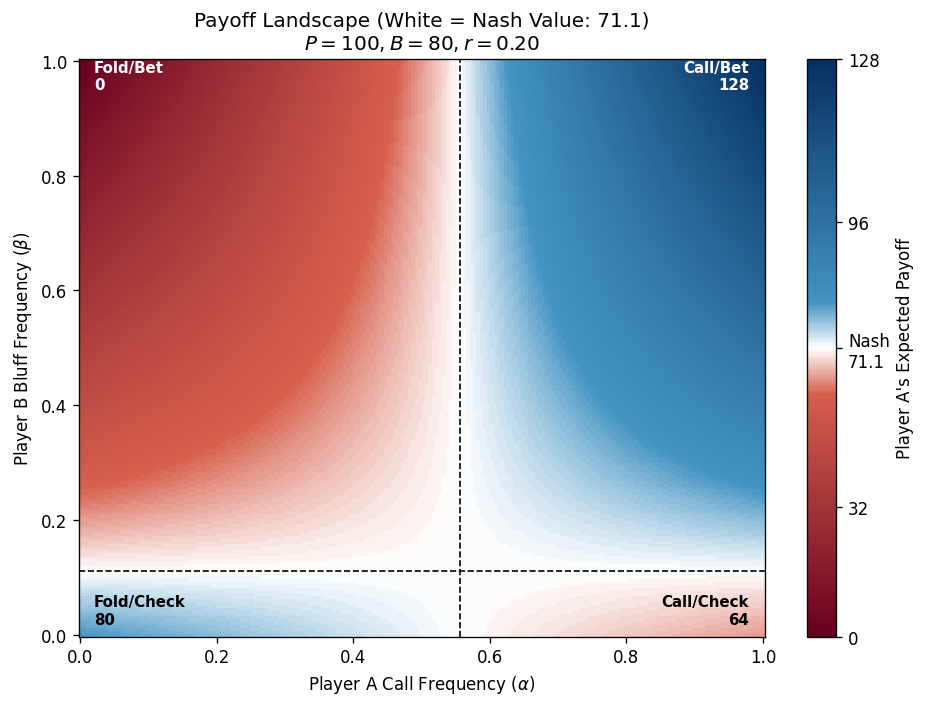

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# --- 1. 參數設定 (維持原本) ---
P = 100.0
B = 80.0
r = 1/5

z_00 = (1 - r) * P 
z_01 = 0.0
z_10 = -r * B + (1 - r) * P
z_11 = -r * B + (1 - r) * (B + P)

resolution = 200
alpha = np.linspace(0, 1, resolution)
beta = np.linspace(0, 1, resolution)
X, Y = np.meshgrid(alpha, beta)
Z = (1-X)*(1-Y)*z_00 + (1-X)*Y*z_01 + X*(1-Y)*z_10 + X*Y*z_11

opt_alpha = P / (P + B)
opt_beta = (r * B) / ((1 - r) * (B + P))
nash_payoff = (1-opt_alpha)*(1-opt_beta)*z_00 + \
              (1-opt_alpha)*opt_beta*z_01 + \
              opt_alpha*(1-opt_beta)*z_10 + \
              opt_alpha*opt_beta*z_11

# ==========================================
# 🎨 2. 解決 "太白 (Too white)" - 擠壓版 Colormap
# ==========================================
# 這裡我們把紅/藍色的起始點往中間 (0.5) 擠壓
# 0.42 ~ 0.58 之間才是淡色，其他地方顏色都會很深
colors = [
    (0.00, "#67001f"), # Deep Red 
    (0.42, "#d6604d"), # Red (提早變深)
    (0.50, "#ffffff"), # White
    (0.58, "#4393c3"), # Blue (提早變深)
    (1.00, "#053061")  # Deep Blue
]
high_contrast_cmap = mcolors.LinearSegmentedColormap.from_list("HighContrastRdBu", colors)

# ==========================================
# 📊 3. 繪圖 & 修復 Colorbar
# ==========================================
fig, ax = plt.subplots(figsize=(8, 6), dpi=120)

divnorm = mcolors.TwoSlopeNorm(vmin=Z.min(), vcenter=nash_payoff, vmax=Z.max())
c = ax.pcolormesh(X, Y, Z, cmap=high_contrast_cmap, norm=divnorm, shading='auto')

# 輔助線
ax.axvline(x=opt_alpha, color='black', linestyle='--', linewidth=1.0)
ax.axhline(y=opt_beta, color='black', linestyle='--', linewidth=1.0)

# 頂點標籤
ax.text(0.02, 0.02, f'Fold/Check\n{z_00:.0f}', color='black', fontsize=9, fontweight='bold')
ax.text(0.02, 0.95, f'Fold/Bet\n{z_01:.0f}', color='white', fontsize=9, fontweight='bold') # 深色區用白字
ax.text(0.98, 0.02, f'Call/Check\n{z_10:.0f}', color='black', fontsize=9, fontweight='bold', ha='right')
ax.text(0.98, 0.95, f'Call/Bet\n{z_11:.0f}', color='white', fontsize=9, fontweight='bold', ha='right') # 深色區用白字

# --- 這裡開始修復 Colorbar ---
cbar = fig.colorbar(c, ax=ax)
cbar.set_label("Player A's Expected Payoff")

# [關鍵修復] 不要依賴 get_ticks()，我們手動產生 5 個刻度
safe_ticks = np.linspace(Z.min(), Z.max(), 5)
# 過濾掉太靠近 Nash 的刻度 (避免重疊)
clean_ticks = [t for t in safe_ticks if abs(t - nash_payoff) > 15] 
# 加入主角 Nash
clean_ticks.append(nash_payoff)
clean_ticks.sort()

# 強制設定 Colorbar 的範圍 (避免被 Matplotlib 亂縮放)
cbar.ax.set_ylim(Z.min(), Z.max()) 
cbar.set_ticks(clean_ticks)

# 設定文字
labels = []
for t in clean_ticks:
    if abs(t - nash_payoff) < 0.001:
        labels.append(f'Nash\n{t:.1f}')
    else:
        labels.append(f'{t:.0f}')
cbar.set_ticklabels(labels)

# ax.set_title(f"Payoff Landscape (White = Nash Value: {nash_payoff:.1f})")
ax.set_title(f"Payoff Landscape (White = Nash Value: {nash_payoff:.1f})\n$P={P:.0f}, B={B:.0f}, r={r:.2f}$")
ax.set_xlabel(r"Player A Call Frequency ($\alpha$)")
ax.set_ylabel(r"Player B Bluff Frequency ($\beta$)")

plt.tight_layout()

# 1. 確保 images 資料夾存在 (防呆機制)
# 如果沒有這個資料夾，Python 會報錯找不到路徑，這行會自動幫你建
import os
os.makedirs('images', exist_ok=True)

# 2. 存檔指令 (Save)
# .png 是最通用的格式
# dpi=300: 高解析度 (Retina 螢幕才不會糊)
# bbox_inches='tight': [關鍵] 自動裁切掉周圍多餘的白邊，讓圖表填滿圖片
plt.savefig('images/payoff_landscape.png', dpi=300, bbox_inches='tight')

# 3. 顯示圖表 (這行要在 savefig 之後，不然有時候圖會被清空)
plt.show()

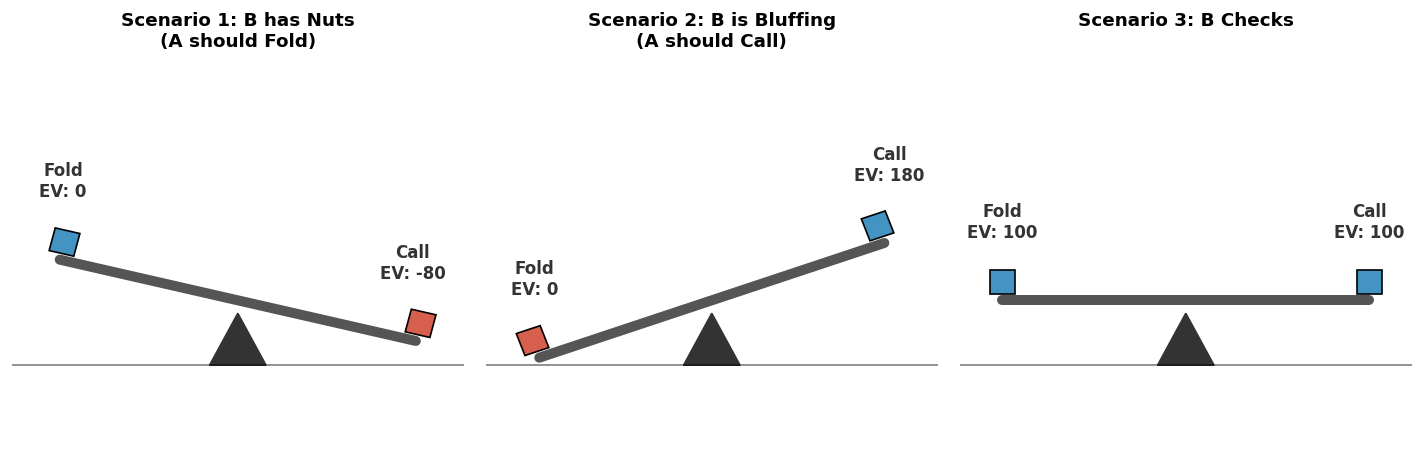

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os

def draw_dynamic_seesaw(ax, title, left_label, left_val, right_label, right_val):
    """
    繪製動態蹺蹺板場景，傾斜角度取決於數值差異。
    """
    # --- 1. 參數設定 ---
    MAX_TILT_DEG = 21.0  # 最大傾斜角度 (度) - 物理極限
    SENSITIVITY = 100.0   # 敏感度係數：數值差距多大時顯著傾斜。
                         # 差距 = SENSITIVITY 時，傾斜約為最大角的 76% (tanh(1))
                         # 差距 = 2 * SENSITIVITY 時，傾斜約為最大角的 96% (tanh(2))

    # --- 2. 計算動態傾斜角度 (核心修改) ---
    diff = right_val - left_val
    
    # 使用 tanh 函數將差異映射到 (-1, 1) 區間，製造 S 型曲線效果
    tilt_ratio = np.tanh(diff / SENSITIVITY)
    
    # 將比例轉換為實際角度
    tilt_factor = tilt_ratio * MAX_TILT_DEG

    # 判斷贏家 (用於上色) - 使用微小公差避免浮點數誤差
    if diff < -1e-5:
        winner = "left" # 左邊重(數值大)，往左下沉
    elif diff > 1e-5:
        winner = "right" # 右邊重，往右下沉
    else:
        winner = "tie"

    # --- 3. 繪圖設置 ---
    ax.set_xlim(-1.6, 1.6) # 稍微加寬一點
    ax.set_ylim(-1.2, 1.8)
    ax.axis('off')
    
    # 畫支點 (Fulcrum)
    triangle = patches.Polygon([[-0.2, -0.5], [0.2, -0.5], [0, -0.1]], closed=True, color='#333333')
    ax.add_patch(triangle)
    
    # --- 4. 畫板子 (Plank) ---
    angle_rad = np.radians(tilt_factor)
    x_len = 1.3 # 板子長度半徑
    
    # 計算旋轉後的端點
    lx = -x_len * np.cos(angle_rad)
    ly = -x_len * np.sin(angle_rad)
    rx = x_len * np.cos(angle_rad)
    ry = x_len * np.sin(angle_rad)
    
    # 畫線代表板子
    ax.plot([lx, rx], [ly, ry], color='#555555', linewidth=6, solid_capstyle='round')
    
    # --- 5. 畫球/箱子 (Weights) ---
    box_size = 0.18
    box_offset_y = 0.05 # 箱子底部距離板子中線的高度

    # 定義顏色 (贏家/較重的一方用藍色強調，輸家用紅色)
    color_win = '#4393c3' # Blue
    color_lose = '#d6604d' # Redish
    
    # 左箱
    c_left = color_win if winner == 'left' else color_lose
    # 如果平手都用藍色
    if winner == 'tie': c_left = color_win

    # 計算左箱中心點，並根據角度旋轉
    # 這裡需要一點幾何計算確保箱子貼在板子上
    lx_box_center = lx + (box_size/2)*np.sin(angle_rad)
    ly_box_center = ly + box_offset_y + (box_size/2)*np.cos(angle_rad)
    
    rect_l = patches.Rectangle((lx - box_size/2, ly + box_offset_y), box_size, box_size, 
                               angle=tilt_factor, rotation_point=(lx, ly),
                               color=c_left, ec='black', lw=1)
    
    # 右箱
    c_right = color_win if winner == 'right' else color_lose
    if winner == 'tie': c_right = color_win
    
    rect_r = patches.Rectangle((rx - box_size/2, ry + box_offset_y), box_size, box_size, 
                               angle=tilt_factor, rotation_point=(rx, ry),
                               color=c_right, ec='black', lw=1)
    
    ax.add_patch(rect_l)
    ax.add_patch(rect_r)
    
    # --- 6. 文字標籤 ---
    # 文字跟隨端點移動，並增加垂直偏移量
    text_offset = 0.45
    
    # 根據傾斜微調文字的水平位置，避免撞到箱子
    l_text_shift = -0.1 * np.sin(angle_rad)
    r_text_shift = 0.1 * np.sin(angle_rad)

    # Left Text
    ax.text(lx + l_text_shift, ly + text_offset, f"{left_label}\nEV: {left_val}", 
            ha='center', va='bottom', fontsize=10, fontweight='bold', color='#333333')
    
    # Right Text
    ax.text(rx + r_text_shift, ry + text_offset, f"{right_label}\nEV: {right_val}", 
            ha='center', va='bottom', fontsize=10, fontweight='bold', color='#333333')

    # Title
    ax.set_title(title, fontsize=11, pad=12, fontweight='bold')
    
    # 地面線
    ax.axhline(y=-0.5, color='black', linewidth=1, alpha=0.5)


# ==========================================
# 主程式執行
# ==========================================

# --- 設定參數 ---
P = 100
B = 80

# 建立畫布
fig, axes = plt.subplots(1, 3, figsize=(12, 4), dpi=120)

# --- 場景 1: B 有 Nuts (Value Bet) ---
# 差異: 0 - (-80) = 80。
# 預期: 左邊重，向左傾斜。傾斜程度中等偏大。
draw_dynamic_seesaw(axes[0], 
                     title="Scenario 1: B has Nuts\n(A should Fold)", 
                     left_label="Fold", left_val=0, 
                     right_label="Call", right_val=-B)

# --- 場景 2: B 是 Air (Bluff) ---
# 差異: 180 - 0 = 180。
# 預期: 右邊重，向右傾斜。差異很大(>SENSITIVITY)，應接近最大傾斜角度。
draw_dynamic_seesaw(axes[1], 
                     title="Scenario 2: B is Bluffing\n(A should Call)", 
                     left_label="Fold", left_val=0, 
                     right_label="Call", right_val=P+B)

# --- 場景 3: B Check (Honest/Give Up) ---
# 差異: 100 - 100 = 0。
# 預期: 完全平衡。
draw_dynamic_seesaw(axes[2], 
                     title="Scenario 3: B Checks\n", 
                     left_label="Fold", left_val=P, 
                     right_label="Call", right_val=P)

plt.tight_layout()

# 存檔
os.makedirs('images', exist_ok=True)
plt.savefig('images/visualize_seesaw.png', dpi=300, bbox_inches='tight')
plt.show()

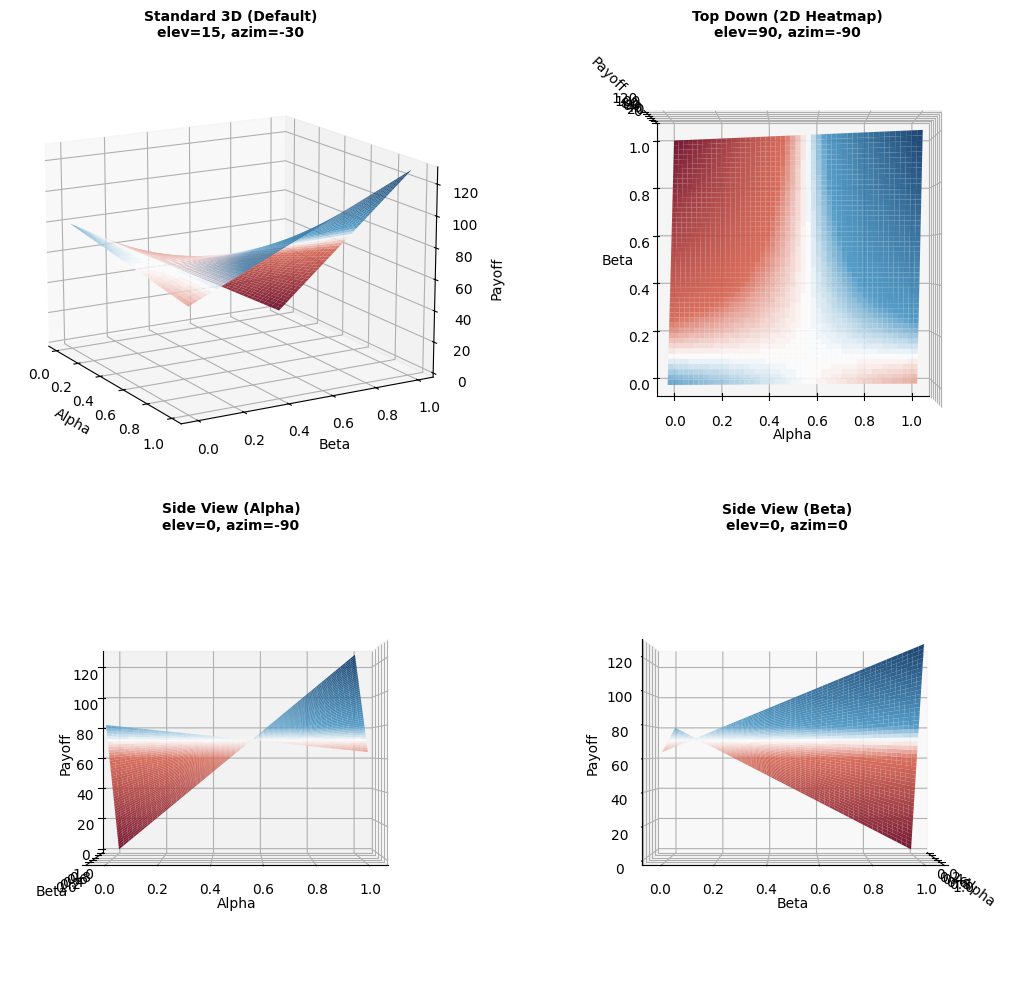

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as mcolors

# --- 1. 資料準備 (同上) ---
P, B, r = 100.0, 80.0, 1/5
z_00 = (1 - r) * P 
z_01 = 0.0
z_10 = -r * B + (1 - r) * P
z_11 = -r * B + (1 - r) * (B + P)

resolution = 50
alpha = np.linspace(0, 1, resolution)
beta = np.linspace(0, 1, resolution)
X, Y = np.meshgrid(alpha, beta)
Z = X * Y * z_11 + X * (1 - Y) * z_10 + (1 - X) * Y * z_01 + (1 - X) * (1 - Y) * z_00

nash_payoff = (z_00*z_11 - z_01*z_10) / (z_00 + z_11 - z_01 - z_10)

# --- 2. 設定四種視角 ---
# 格式: (Elevation, Azimuth, Title)
views = [
    (15, -30, "Standard 3D (Default)"),  # 標準視角
    (90, -90, "Top Down (2D Heatmap)"),  # 正上方 (像 Heatmap)
    (0, -90, "Side View (Alpha)"),       # 正側面 (看高低起伏)
    (0, 0, "Side View (Beta)")       # 
    # (20, 45, "Corner View (Back)")       # 另一個對角
]

# --- 3. 繪圖 ---
colors = [
    (0.00, "#67001f"), # Deep Red 
    (0.42, "#d6604d"), # Red (提早變深)
    (0.50, "#ffffff"), # White
    (0.58, "#4393c3"), # Blue (提早變深)
    (1.00, "#053061")  # Deep Blue
]
high_contrast_cmap = mcolors.LinearSegmentedColormap.from_list("HighContrastRdBu", colors)
divnorm = mcolors.TwoSlopeNorm(vmin=Z.min(), vcenter=nash_payoff, vmax=Z.max())

fig = plt.figure(figsize=(12, 10), dpi=100)

for i, (elev, azim, title) in enumerate(views):
    ax = fig.add_subplot(2, 2, i+1, projection='3d')
    
    surf = ax.plot_surface(X, Y, Z, cmap=high_contrast_cmap, norm=divnorm, edgecolor='none', alpha=0.9, antialiased=True)
    


    # [關鍵] 設定視角
    ax.view_init(elev=elev, azim=azim)
    
    ax.set_title(f"{title}\nelev={elev}, azim={azim}", fontsize=10, fontweight='bold')
    ax.set_xlabel('Alpha')
    ax.set_ylabel('Beta')
    ax.set_zlabel('Payoff')

plt.tight_layout()
plt.show()